# Negative sampling

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling. In more detail: you should implement two ways of negative sampling.

## Vanilla negative sampling

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j, u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution, but it is better to use $P^{3/4}(w)$ (empirical results) and you can experiment with some other approaches (for example, try to use uniform distribution).

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

## Batch-transpose trick for negative sampling

But we can do better. Maybe we don't need to compute vectors for negative samples at all, because we already have a batch of training data and (hopefully) examples in the batch are highly decorrelated.

Let's assume we work with Skip-gram model.

Let $S$ be a batch of _L2-normalized_ word vectors `(batch_size, 2*window_size + 1, word_vector_dim)`.

```python
x = 0.0
for batch_idx in range(batch):
    w = S[batch_idx, :, :]
    x += np.sum(w.T @ w - 1.)

y = 0.0
for window_idx in range(window):
    b = S[:, window_idx, :]
    y += np.sum(b.T @ b)

loss = -x + y```

Think about this loss and compare it to vanilla negative sampling.

Implement word2vec with batch-transpose trick. Modify the formula, if needed.

If you are interested: [more info](https://www.tensorflow.org/extras/candidate_sampling.pdf) on other methods of candidate sampling.

**Results of this task** are the very same as in task 3, **plus**:
 * implement two models (one with vanilla negative sampling and the other with batch-transpose trick)
 * compare all of the models from tasks 3-5. In terms of time and number of iterations until convergence and the quality of the resulting vectors.
 * answer the questions

### Questions:
1. Explain the batch-transpose trick formula in your own words. How would you name x, y, w and b?
1. Should it be modified to serve as a word2vec loss? If yes, how?
1. Is it possible to do the same trick with CBOW model? If yes, how?
1. Does it matter how the batch is made in the case of batch-transpose trick? In the case of vanilla negative sampling?




## Answers:
  1. _
  1. _
  1. _
  1. _

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import optim
from torch import nn
from torch.nn.init import kaiming_normal_

In [3]:
class CBOW_negative_sampling(nn.Module):
    def __init__(self, vocab_size, probs, hidden_size, neg_number, device):
        super(CBOW_negative_sampling, self).__init__()
        self.neg_number = neg_number
        
        self.encode_layer = nn.Embedding(num_embeddings=vocab_size+1, 
                                         embedding_dim=hidden_size,
                                         sparse=False).to(device)
        self.decode_layer = nn.Embedding(num_embeddings=vocab_size+1, 
                                         embedding_dim=hidden_size,
                                         sparse=False).to(device)
        
        self.encode_layer.weight.data = kaiming_normal_(self.encode_layer.weight.data)
        self.decode_layer.weight.data = kaiming_normal_(self.encode_layer.weight.data)
        
        self.probs = torch.DoubleTensor(probs).to(device)
       
    def forward(self, x, y):
        context = self.encode_layer(x).mean(dim=1) 
        
        pos_embs = self.decode_layer(y)
        pos_activations = (context * pos_embs).sum(dim=1)
        
        neg_tokens = torch.multinomial(self.probs, self.neg_number)
        neg_embs = self.decode_layer(neg_tokens)
        neg_activations = torch.matmul(neg_embs, context.unsqueeze(2)).squeeze(2)
        
        return torch.sigmoid(pos_activations), torch.sigmoid(neg_activations)

In [4]:
from part2 import process_corpus, build_vocab, CBOWBatcher

In [5]:
batcher = CBOWBatcher(batch_size=128, window_size=5, shuffle=True)

In [6]:
corpus = process_corpus('text8')

In [7]:
vocab = build_vocab(corpus, min_freq=5)

In [8]:
batcher.init(corpus, vocab)

In [9]:
from collections import Counter
c = Counter()
for sent in corpus:
    c.update(sent)

In [10]:
probs = [c[batcher.ind2word[i]] for i in range(len(batcher.ind2word))]
probs = np.array(probs) ** (3/4)

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [12]:
model = CBOW_negative_sampling(vocab_size=len(vocab), 
                               probs=probs, 
                               hidden_size=300, 
                               neg_number=5, 
                               device=device)

In [13]:
optimizer = optim.SGD(params=model.parameters(), lr=1e-2, weight_decay=1e-6)

In [14]:
# optimizer = optim.SparseAdam(params=model.parameters(), lr=1e-2)

In [15]:
eps = torch.tensor(1e-6, dtype=torch.double).to(device)

In [16]:
eps

tensor(1.0000e-06, device='cuda:0', dtype=torch.float64)

In [17]:
losses = []

for epoch in range(30):
    for i, (x, y) in tqdm(enumerate(batcher)):
        x_torch = torch.LongTensor(x).to(device)
        y_torch = torch.LongTensor(y).to(device)
        
        pos, neg = model(x_torch, y_torch)
        loss = (
            -torch.log(torch.clamp(pos, min=eps, max=1-eps))
            + torch.log(torch.clamp(neg, min=eps, max=1-eps)).sum(dim=1)).mean() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(float(loss.cpu().data.numpy()))
        if (i + 1) % 1000 == 0:
            print(np.mean(losses[-1000:]))

1006it [00:21, 48.81it/s]

-2.9636809511184694


2006it [00:42, 48.41it/s]

-3.0274886610507967


3006it [01:02, 48.26it/s]

-3.07708922624588


4006it [01:23, 48.13it/s]

-3.1040189645290375


5006it [01:44, 48.67it/s]

-3.184179412126541


6006it [02:04, 47.92it/s]

-3.231691330432892


7006it [02:25, 48.00it/s]

-3.368940570831299


8006it [02:46, 48.06it/s]

-3.620232270002365


9006it [03:07, 48.09it/s]

-3.837833838939667


10006it [03:28, 48.16it/s]

-4.4355059183835985


11006it [03:48, 48.28it/s]

-4.811360213875771


12006it [04:09, 48.10it/s]

-5.313151183009148


13006it [04:30, 48.34it/s]

-5.562687245845795


14006it [04:50, 48.20it/s]

-6.124525730252266


15006it [05:11, 48.19it/s]

-6.43686339777708


16006it [05:32, 48.27it/s]

-7.273559393405915


17006it [05:52, 48.22it/s]

-7.413176572144032


18006it [06:13, 48.23it/s]

-8.525695644780994


19006it [06:34, 48.06it/s]

-9.854057023331523


20006it [06:55, 48.22it/s]

-10.963835464172066


21006it [07:15, 48.26it/s]

-12.529254503086209


22006it [07:36, 48.21it/s]

-13.76788006915152


23006it [07:57, 48.20it/s]

-16.125215136013924


24006it [08:18, 48.44it/s]

-17.66128098551929


25006it [08:38, 48.24it/s]

-19.391214062303305


26006it [08:59, 48.21it/s]

-21.696195606425405


27006it [09:20, 48.19it/s]

-22.79194484743476


28006it [09:40, 48.25it/s]

-23.76389673730731


29006it [10:01, 48.21it/s]

-25.84112861046195


30006it [10:22, 48.15it/s]

-27.1783867996037


31006it [10:43, 48.19it/s]

-28.847987499833106


32006it [11:03, 48.29it/s]

-29.765155578427017


33006it [11:24, 48.23it/s]

-30.429071294099092


34006it [11:45, 48.14it/s]

-31.973433676578104


35006it [12:05, 48.20it/s]

-31.865828295737504


36006it [12:26, 48.28it/s]

-33.18376500964165


37006it [12:47, 48.21it/s]

-34.30058907067776


38006it [13:08, 48.77it/s]

-35.22252468466759


39006it [13:28, 48.26it/s]

-35.07547414016724


40006it [13:49, 48.22it/s]

-36.38036825916171


41006it [14:10, 48.17it/s]

-37.06123903036118


42006it [14:30, 48.18it/s]

-37.930392517328265


43006it [14:51, 48.23it/s]

-39.045793417930604


44006it [15:12, 48.12it/s]

-38.78779148769379


45006it [15:33, 48.10it/s]

-39.83943864583969


46006it [15:53, 48.27it/s]

-39.424523271083835


47006it [16:14, 48.18it/s]

-39.55237450060248


48006it [16:35, 48.26it/s]

-40.43139650225639


49006it [16:55, 48.24it/s]

-40.577558501720425


50006it [17:16, 48.20it/s]

-41.39990123209357


51006it [17:37, 48.23it/s]

-41.62494726371765


52006it [17:58, 48.17it/s]

-42.49489769268036


53006it [18:18, 48.09it/s]

-42.09041530439258


54006it [18:39, 48.24it/s]

-42.86372755122185


55006it [19:00, 48.15it/s]

-42.73656095981598


56006it [19:21, 48.22it/s]

-43.539595608711245


57006it [19:41, 48.30it/s]

-44.36253132152557


58006it [20:02, 48.18it/s]

-44.02604620504379


59006it [20:23, 48.18it/s]

-44.75327839064598


60006it [20:43, 48.23it/s]

-44.37345998048782


61006it [21:04, 48.20it/s]

-44.84937068986893


62006it [21:25, 48.21it/s]

-44.96685369777679


63006it [21:46, 48.27it/s]

-45.441892028808596


64006it [22:06, 48.20it/s]

-45.356953630924224


65006it [22:27, 48.22it/s]

-46.047021293640135


66006it [22:48, 48.23it/s]

-45.401779291152955


67006it [23:09, 48.10it/s]

-46.09473861980438


68006it [23:29, 48.39it/s]

-46.559413805425166


69006it [23:50, 48.21it/s]

-46.25336500644684


70006it [24:11, 48.20it/s]

-46.60574160003662


71006it [24:31, 48.24it/s]

-46.53513808727264


72006it [24:52, 48.53it/s]

-46.49160685253143


73006it [25:13, 48.48it/s]

-47.87679243278503


74006it [25:33, 48.57it/s]

-47.856843977928165


75006it [25:54, 48.59it/s]

-48.21492481422424


76006it [26:15, 48.13it/s]

-47.48171802902222


77006it [26:35, 48.24it/s]

-48.042172958374024


78006it [26:56, 48.18it/s]

-47.72113966560364


79006it [27:16, 48.60it/s]

-47.918103108406065


80006it [27:37, 48.52it/s]

-48.41585869026184


81006it [27:58, 48.59it/s]

-48.202866364479064


82006it [28:18, 48.58it/s]

-48.54814845085144


83006it [28:39, 48.22it/s]

-48.49610307502746


84006it [28:59, 48.26it/s]

-48.591299018859864


85006it [29:20, 48.14it/s]

-49.133577910900115


86006it [29:41, 48.07it/s]

-48.98499559020996


87006it [30:01, 48.14it/s]

-49.63708944702149


88006it [30:22, 48.39it/s]

-49.38086887550354


89006it [30:43, 48.06it/s]

-49.43896666145325


90006it [31:04, 48.03it/s]

-49.77113494873047


91006it [31:24, 48.21it/s]

-49.418768043041226


92006it [31:45, 48.25it/s]

-49.955877089977264


93006it [32:06, 48.22it/s]

-49.492395053863525


94006it [32:27, 48.18it/s]

-49.67471384048462


95006it [32:47, 48.24it/s]

-49.925198175430296


96006it [33:08, 48.07it/s]

-50.32709559631348


97006it [33:29, 48.43it/s]

-50.21751720428467


98006it [33:49, 48.20it/s]

-50.24793504142761


99006it [34:10, 48.31it/s]

-50.487058614730834


100006it [34:31, 48.39it/s]

-50.45883911514282


101006it [34:51, 48.23it/s]

-50.867033682346346


102006it [35:12, 48.30it/s]

-50.10528952407837


103006it [35:33, 48.42it/s]

-50.348037815093996


104006it [35:53, 48.47it/s]

-50.87951090621948


105006it [36:14, 48.26it/s]

-50.81813305282593


106006it [36:35, 48.35it/s]

-50.97620327091217


107006it [36:55, 48.56it/s]

-50.40818152618408


108006it [37:16, 48.41it/s]

-51.27918055534363


109006it [37:37, 48.18it/s]

-51.13951893615722


110006it [37:57, 48.08it/s]

-51.118852502822875


111006it [38:18, 48.29it/s]

-51.19108105659485


112006it [38:39, 48.81it/s]

-51.08973324203491


113006it [38:59, 48.86it/s]

-51.09293353843689


114006it [39:20, 48.28it/s]

-51.77350372886658


115006it [39:40, 48.28it/s]

-51.3920722951889


116006it [40:01, 48.08it/s]

-52.11024347114563


117006it [40:22, 48.11it/s]

-51.81783218955994


118006it [40:43, 48.06it/s]

-51.85789459037781


119006it [41:03, 48.75it/s]

-52.09234994697571


120006it [41:24, 48.15it/s]

-51.85935276794434


121006it [41:45, 48.04it/s]

-52.1311567363739


122006it [42:05, 48.89it/s]

-52.12195941066742


123006it [42:26, 48.44it/s]

-52.172781167984006


124006it [42:47, 48.26it/s]

-51.90785787963867


125006it [43:07, 48.77it/s]

-52.56171172332763


126006it [43:28, 48.55it/s]

-52.139704312324525


127006it [43:49, 48.26it/s]

-52.29946275901794


128006it [44:09, 48.35it/s]

-52.54232270336151


129006it [44:30, 48.30it/s]

-52.36725911521911


130006it [44:51, 48.23it/s]

-52.233870080947874


131006it [45:12, 48.28it/s]

-52.68664965820312


132006it [45:32, 48.39it/s]

-52.77672108650208


132873it [45:50, 48.31it/s]
1006it [00:21, 48.06it/s]

-52.18007706069946


2006it [00:42, 48.50it/s]

-52.76707804107666


3006it [01:03, 48.11it/s]

-52.774120975494384


4006it [01:23, 48.78it/s]

-52.61838423919678


5006it [01:44, 48.79it/s]

-52.9247555770874


6006it [02:04, 48.78it/s]

-52.89272224903107


7006it [02:25, 48.00it/s]

-52.81687842559815


8006it [02:46, 48.19it/s]

-52.79290402507782


9006it [03:06, 48.67it/s]

-53.273812925338746


10006it [03:27, 48.76it/s]

-53.31314740371704


11006it [03:47, 48.53it/s]

-52.80326568412781


12006it [04:08, 48.03it/s]

-52.91207929611206


13006it [04:29, 48.20it/s]

-53.35350610351563


14006it [04:50, 48.49it/s]

-53.111985834121704


15006it [05:10, 48.52it/s]

-53.161639434814454


16006it [05:31, 48.07it/s]

-52.818084033966066


17006it [05:52, 48.41it/s]

-53.40192630195617


18006it [06:12, 48.27it/s]

-53.31279097747803


19006it [06:33, 48.08it/s]

-53.314356191635135


20006it [06:54, 48.79it/s]

-53.47580402183533


21006it [07:14, 48.71it/s]

-53.18871000099182


22006it [07:35, 48.17it/s]

-53.65735791969299


23006it [07:55, 48.26it/s]

-53.50996981811524


24006it [08:16, 48.18it/s]

-53.874658172607425


25006it [08:37, 48.20it/s]

-53.70031527519226


26006it [08:58, 48.21it/s]

-53.182983386993406


27006it [09:18, 48.50it/s]

-53.376791877746584


28006it [09:39, 48.45it/s]

-53.35413621520996


29006it [10:00, 48.42it/s]

-53.63619152832031


30006it [10:20, 48.42it/s]

-53.74468274879455


31006it [10:41, 48.05it/s]

-53.895338954925535


32006it [11:02, 48.07it/s]

-53.98076090049744


33006it [11:22, 48.52it/s]

-53.57024456214905


34006it [11:43, 48.08it/s]

-53.81152786254883


35006it [12:04, 48.06it/s]

-53.985199003219606


36006it [12:25, 47.69it/s]

-53.81658742904663


37006it [12:45, 48.28it/s]

-53.9833270778656


38006it [13:06, 48.23it/s]

-53.749297008514404


39006it [13:27, 48.20it/s]

-53.84968441390991


40006it [13:47, 48.20it/s]

-53.89595516204834


41006it [14:08, 48.26it/s]

-54.053217905044555


42006it [14:29, 48.20it/s]

-54.37295367622375


43006it [14:50, 48.24it/s]

-54.28235049915314


44006it [15:10, 48.23it/s]

-53.83626880455017


45006it [15:31, 48.03it/s]

-54.41111836624145


46006it [15:52, 48.12it/s]

-54.46870335960388


47006it [16:12, 48.21it/s]

-53.89339637565613


48006it [16:33, 48.22it/s]

-54.14338613700867


49006it [16:54, 48.25it/s]

-54.09123547744751


50006it [17:15, 48.30it/s]

-53.88443102455139


51006it [17:35, 48.11it/s]

-54.3128692111969


52006it [17:56, 48.34it/s]

-54.60770426750183


53006it [18:17, 48.21it/s]

-54.41575297355652


54006it [18:37, 48.23it/s]

-54.36049053955078


55006it [18:58, 48.30it/s]

-54.17541155433655


56006it [19:19, 48.22it/s]

-54.62345081710816


57006it [19:39, 48.29it/s]

-54.628587575912476


58006it [20:00, 48.21it/s]

-54.57875340461731


59006it [20:21, 48.29it/s]

-54.62271170043945


60006it [20:42, 48.19it/s]

-54.71416736221313


61006it [21:02, 48.28it/s]

-54.50367982673645


62006it [21:23, 48.16it/s]

-54.64436596298218


63006it [21:44, 48.22it/s]

-54.663836654663086


64006it [22:04, 48.26it/s]

-54.55429912376404


65006it [22:25, 48.47it/s]

-54.90008406829834


66006it [22:46, 48.22it/s]

-54.644818187713625


67006it [23:07, 48.22it/s]

-54.93491942024231


68006it [23:27, 48.27it/s]

-54.94880827140808


69006it [23:48, 48.18it/s]

-54.6157942905426


70006it [24:09, 48.40it/s]

-54.99121306228638


71006it [24:29, 48.44it/s]

-54.751829315185546


72006it [24:50, 47.90it/s]

-54.64978860855103


73006it [25:11, 47.99it/s]

-54.8604272480011


74006it [25:31, 48.31it/s]

-54.84845441436767


75006it [25:52, 48.34it/s]

-55.03247736167908


76006it [26:13, 48.27it/s]

-54.691350429534914


77006it [26:34, 48.30it/s]

-54.794946823120114


78006it [26:54, 48.35it/s]

-54.66703451919555


79006it [27:15, 47.98it/s]

-54.90889708900452


80006it [27:36, 48.37it/s]

-55.037948949813845


81006it [27:56, 48.37it/s]

-55.18052455329895


82006it [28:17, 48.41it/s]

-54.80277833175659


83006it [28:38, 48.44it/s]

-54.93716478919983


84006it [28:58, 48.42it/s]

-54.891538408279416


85006it [29:19, 48.33it/s]

-54.735931480407714


86006it [29:40, 48.37it/s]

-55.04703028678894


87006it [30:00, 48.39it/s]

-55.1334750995636


88006it [30:21, 48.38it/s]

-55.187536567687985


89006it [30:42, 48.46it/s]

-55.40010620880127


90006it [31:02, 48.40it/s]

-55.26658090209961


91006it [31:23, 48.09it/s]

-55.118274938583376


92006it [31:44, 48.14it/s]

-55.021504819869996


93006it [32:04, 48.78it/s]

-55.390841638565064


94006it [32:25, 48.16it/s]

-55.34660909080505


95006it [32:46, 48.10it/s]

-55.11781416130066


96006it [33:06, 48.36it/s]

-55.3432068977356


97006it [33:27, 48.35it/s]

-55.39405094337464


98006it [33:48, 48.27it/s]

-55.03056532096863


99006it [34:08, 48.28it/s]

-55.520989627838134


100006it [34:29, 48.17it/s]

-55.364511486053466


101006it [34:50, 48.27it/s]

-55.421677612304684


102006it [35:10, 48.23it/s]

-55.42171081542969


103006it [35:31, 48.79it/s]

-54.98397337150574


104006it [35:51, 48.23it/s]

-55.48095391654968


105006it [36:12, 48.29it/s]

-55.220399225234985


106006it [36:33, 48.39it/s]

-55.30413444137573


107006it [36:53, 48.29it/s]

-55.323011943817136


108006it [37:14, 48.37it/s]

-55.48767590904236


109006it [37:35, 48.20it/s]

-55.394355676651


110006it [37:56, 48.31it/s]

-55.508472049713134


111006it [38:16, 48.35it/s]

-55.587254650115966


112006it [38:37, 48.16it/s]

-55.744144874572754


113006it [38:58, 48.47it/s]

-55.57574132537842


114006it [39:18, 48.10it/s]

-55.806790754318236


115006it [39:39, 48.69it/s]

-55.80032908821106


116006it [40:00, 48.07it/s]

-55.43130291557312


117006it [40:21, 48.10it/s]

-55.704751525878905


118006it [40:41, 48.03it/s]

-55.58038147926331


119006it [41:02, 48.30it/s]

-55.56713163948059


120006it [41:23, 48.07it/s]

-55.609467868804934


121006it [41:43, 48.17it/s]

-55.71090993881226


122006it [42:04, 48.19it/s]

-55.79885524940491


123006it [42:25, 48.33it/s]

-55.738164741516115


124006it [42:46, 48.33it/s]

-55.6618433265686


125006it [43:06, 48.22it/s]

-55.613944725036625


126006it [43:27, 48.53it/s]

-55.96764947128296


127006it [43:48, 48.49it/s]

-55.60282304763794


128006it [44:08, 48.09it/s]

-55.41978764152527


129006it [44:29, 48.32it/s]

-55.5183425693512


130006it [44:50, 48.27it/s]

-55.807467821121215


131006it [45:10, 48.63it/s]

-55.75496161079407


132006it [45:31, 48.65it/s]

-55.74835007095337


132873it [45:49, 48.33it/s]
1006it [00:21, 48.78it/s]

-55.599903427124026


2006it [00:42, 48.30it/s]

-56.035447875976566


3006it [01:02, 48.21it/s]

-55.68095387649536


4006it [01:23, 48.21it/s]

-55.7570655670166


5006it [01:44, 48.57it/s]

-55.61718137550354


6006it [02:04, 48.19it/s]

-55.89929482650757


7006it [02:25, 48.16it/s]

-55.90267211151123


8006it [02:46, 48.10it/s]

-56.0421977519989


9006it [03:07, 48.22it/s]

-56.27717733192444


10006it [03:27, 48.23it/s]

-56.17232345199585


11006it [03:48, 48.23it/s]

-55.99787209701538


12006it [04:09, 48.44it/s]

-55.93693034172058


13006it [04:29, 48.28it/s]

-56.320123626708984


14006it [04:50, 48.81it/s]

-55.992255290985106


15006it [05:10, 48.31it/s]

-55.934216974258426


16006it [05:31, 48.86it/s]

-56.114277269363406


17006it [05:51, 48.88it/s]

-55.750095964431765


18006it [06:12, 48.87it/s]

-55.78396529769898


19006it [06:32, 48.82it/s]

-56.18097983932495


20006it [06:53, 48.59it/s]

-55.93370806121826


21006it [07:14, 47.98it/s]

-56.03633543205261


22006it [07:34, 48.06it/s]

-55.928538961410524


23006it [07:55, 48.15it/s]

-56.36972736930847


24006it [08:16, 48.10it/s]

-56.10890942382812


25006it [08:37, 48.18it/s]

-55.90817280006409


26006it [08:58, 48.19it/s]

-56.173672342300414


27006it [09:18, 48.72it/s]

-56.16876150512695


28006it [09:39, 48.76it/s]

-56.246689754486084


29006it [09:59, 48.12it/s]

-56.286441667556765


30006it [10:20, 48.16it/s]

-56.212303115844726


31006it [10:41, 48.53it/s]

-56.04254643440247


32006it [11:01, 48.17it/s]

-55.94817407798767


33006it [11:22, 48.78it/s]

-56.25887922286987


34006it [11:42, 47.97it/s]

-56.28445873069763


35006it [12:03, 48.79it/s]

-56.19082424736023


36006it [12:24, 48.37it/s]

-56.071591346740725


37006it [12:44, 48.34it/s]

-56.37019535446167


38006it [13:05, 48.28it/s]

-56.348403955459595


39006it [13:26, 48.29it/s]

-56.344689249038694


40006it [13:46, 48.36it/s]

-56.29708365631104


41006it [14:07, 48.26it/s]

-56.061300212860104


42006it [14:28, 48.34it/s]

-56.16067914009094


43006it [14:48, 48.27it/s]

-56.33987881851196


44006it [15:09, 48.29it/s]

-56.0197241859436


45006it [15:30, 48.34it/s]

-56.258477710723874


46006it [15:50, 48.26it/s]

-56.456661140441895


47006it [16:11, 48.04it/s]

-55.94993738555908


48006it [16:32, 48.05it/s]

-56.36957395172119


49006it [16:53, 47.94it/s]

-56.40337023544311


50006it [17:13, 47.92it/s]

-56.58375631523133


51006it [17:34, 48.01it/s]

-56.60822826194763


52006it [17:55, 48.05it/s]

-56.44042691421509


53006it [18:16, 48.06it/s]

-56.434325471878054


54006it [18:37, 48.19it/s]

-56.320258375167846


55006it [18:57, 48.01it/s]

-56.605632236480716


56006it [19:18, 48.01it/s]

-56.24094690132141


57006it [19:39, 48.03it/s]

-56.49313569831848


58006it [20:00, 48.37it/s]

-56.33468944168091


59006it [20:20, 48.34it/s]

-56.69306665802002


60006it [20:41, 48.38it/s]

-56.520274703979496


61006it [21:02, 48.38it/s]

-56.42565622520447


62006it [21:22, 48.28it/s]

-56.449351766586304


63006it [21:43, 48.01it/s]

-56.534430671691894


64006it [22:04, 48.17it/s]

-56.47975963592529


65006it [22:25, 48.25it/s]

-56.384056489944456


66006it [22:45, 48.05it/s]

-56.549636814117434


67006it [23:06, 48.21it/s]

-55.9864727344513


68006it [23:27, 48.25it/s]

-56.47875094604492


69006it [23:47, 48.01it/s]

-56.70969652938843


70006it [24:08, 47.91it/s]

-56.28368625450134


71006it [24:29, 48.07it/s]

-56.49244515800476


72006it [24:50, 48.28it/s]

-56.717373600006106


73006it [25:11, 48.01it/s]

-56.49050224113464


74006it [25:31, 48.00it/s]

-56.47769622993469


75006it [25:52, 48.04it/s]

-56.747520109176634


76006it [26:13, 48.16it/s]

-56.53522783088684


77006it [26:34, 47.98it/s]

-56.652849590301514


78006it [26:54, 48.20it/s]

-56.64769323348999


79006it [27:15, 48.38it/s]

-56.527110027313235


80006it [27:36, 48.25it/s]

-56.254389709472655


81006it [27:57, 48.27it/s]

-56.761104007720945


82006it [28:17, 48.11it/s]

-56.85394565200806


83006it [28:38, 48.01it/s]

-56.67695648384094


84006it [28:59, 48.13it/s]

-56.79130946159363


85006it [29:19, 48.29it/s]

-56.459818746566775


86006it [29:40, 48.36it/s]

-56.73051670455933


87006it [30:01, 48.38it/s]

-56.778612087249755


88006it [30:22, 48.36it/s]

-56.840504695892335


89006it [30:42, 48.35it/s]

-56.76325131225586


90006it [31:03, 48.31it/s]

-56.736308898925785


91006it [31:24, 48.34it/s]

-56.86841114044189


92006it [31:44, 48.20it/s]

-56.7262900314331


93006it [32:05, 48.78it/s]

-56.700649938583375


94006it [32:25, 48.73it/s]

-56.98860531234741


95006it [32:46, 48.31it/s]

-56.46780747032165


96006it [33:07, 48.33it/s]

-56.801100828170775


97006it [33:27, 48.40it/s]

-56.79855382156372


98006it [33:48, 48.41it/s]

-56.665809490203856


99006it [34:09, 48.31it/s]

-56.8988749294281


100006it [34:29, 48.33it/s]

-56.594034212112426


101006it [34:50, 48.35it/s]

-56.83344232559204


102006it [35:11, 48.29it/s]

-56.65001935768127


103006it [35:31, 48.30it/s]

-57.161511169433595


104006it [35:52, 48.36it/s]

-56.73295183181763


105006it [36:13, 47.96it/s]

-57.03047966003418


106006it [36:34, 48.16it/s]

-56.92929372406006


107006it [36:54, 48.44it/s]

-57.133539974212646


108006it [37:15, 48.16it/s]

-56.77008060836792


109006it [37:36, 48.08it/s]

-56.681432224273685


110006it [37:57, 48.06it/s]

-56.976146717071536


111006it [38:17, 48.73it/s]

-56.926657348632816


112006it [38:38, 48.15it/s]

-56.83609854888916


113006it [38:58, 48.18it/s]

-56.78293288421631


114006it [39:19, 48.06it/s]

-57.00625915336609


115006it [39:40, 48.48it/s]

-57.1318360786438


116006it [40:00, 48.11it/s]

-56.77724120330811


117006it [40:21, 48.17it/s]

-56.99369116973877


118006it [40:42, 48.55it/s]

-56.87982955932617


119006it [41:03, 48.46it/s]

-56.849108030319215


120006it [41:23, 48.10it/s]

-57.038457118988035


121006it [41:44, 48.35it/s]

-57.15408885955811


122006it [42:05, 48.73it/s]

-57.029297700881955


123006it [42:25, 48.74it/s]

-57.14001487731934


124006it [42:46, 48.14it/s]

-56.97449649620056


125006it [43:07, 48.48it/s]

-57.25319433403015


126006it [43:27, 48.54it/s]

-56.953470859527584


127006it [43:48, 48.52it/s]

-57.11766608428955


128006it [44:09, 48.06it/s]

-57.13026103591919


129006it [44:29, 48.08it/s]

-57.325522304534914


130006it [44:50, 48.59it/s]

-57.11615045547485


131006it [45:11, 48.53it/s]

-56.88361152648926


132006it [45:31, 48.17it/s]

-57.39465704727173


132873it [45:49, 48.32it/s]
1006it [00:21, 48.79it/s]

-56.96962925720215


2006it [00:42, 48.03it/s]

-57.20173136901855


3006it [01:02, 48.08it/s]

-57.14003939437866


4006it [01:23, 48.81it/s]

-56.919228784561156


5006it [01:44, 48.80it/s]

-57.12990025138855


6006it [02:04, 48.11it/s]

-57.422998924255374


7006it [02:25, 48.09it/s]

-57.35702402496338


8006it [02:45, 48.48it/s]

-57.38553134536743


9006it [03:06, 48.20it/s]

-57.213683456420895


10006it [03:27, 48.16it/s]

-57.08582884216309


11006it [03:48, 48.11it/s]

-57.06452271080017


12006it [04:08, 48.43it/s]

-57.08452587890625


13006it [04:29, 48.56it/s]

-57.24976140975952


14006it [04:49, 48.12it/s]

-56.98784160423279


15006it [05:10, 48.12it/s]

-57.29473297309875


16006it [05:31, 48.20it/s]

-57.37952764892578


17006it [05:52, 48.09it/s]

-57.28002465438843


18006it [06:13, 48.07it/s]

-57.31221752929687


19006it [06:33, 48.15it/s]

-57.25305292510986


20006it [06:54, 48.10it/s]

-57.21684420776367


21006it [07:15, 48.16it/s]

-57.478442691802975


22006it [07:36, 48.07it/s]

-57.365785646438596


23006it [07:56, 48.09it/s]

-57.260700786590576


24006it [08:17, 48.15it/s]

-57.266278812408444


25006it [08:38, 48.55it/s]

-57.23374602890015


26006it [08:58, 48.48it/s]

-57.26616111755371


27006it [09:19, 48.56it/s]

-57.443759395599365


28006it [09:39, 48.55it/s]

-57.51815574264526


29006it [10:00, 48.55it/s]

-57.419472156524655


30006it [10:21, 48.53it/s]

-57.09375936317444


31006it [10:41, 48.69it/s]

-57.41791985702515


32006it [11:02, 48.77it/s]

-57.311680234909055


33006it [11:22, 48.55it/s]

-57.339315729141234


34006it [11:43, 48.18it/s]

-57.592063777923585


35006it [12:04, 48.72it/s]

-57.35823000717163


36006it [12:24, 48.78it/s]

-57.38910240364075


37006it [12:45, 48.54it/s]

-57.41223195648193


38006it [13:05, 48.08it/s]

-57.471783294677735


39006it [13:26, 48.07it/s]

-57.337310340881345


40006it [13:47, 48.19it/s]

-57.53713021469116


41006it [14:08, 48.52it/s]

-57.20363563346863


42006it [14:28, 48.44it/s]

-57.639083625793454


43006it [14:49, 48.42it/s]

-57.15060565948486


44006it [15:09, 48.76it/s]

-57.63684645462036


45006it [15:30, 48.68it/s]

-57.17887361717224


46006it [15:51, 48.68it/s]

-57.326602836608885


47006it [16:11, 48.54it/s]

-57.44817582321167


48006it [16:32, 48.15it/s]

-57.28914932823181


49006it [16:53, 48.22it/s]

-57.50582205963135


50006it [17:13, 48.80it/s]

-57.436847990036014


51006it [17:34, 48.14it/s]

-57.341354673385624


52006it [17:55, 48.04it/s]

-57.59964435195923


53006it [18:16, 48.52it/s]

-57.24986125946045


54006it [18:36, 48.13it/s]

-57.35355902481079


55006it [18:57, 48.06it/s]

-57.63089688110352


56006it [19:18, 48.09it/s]

-57.67995093536377


57006it [19:39, 48.11it/s]

-57.28306465339661


58006it [19:59, 48.15it/s]

-57.404267110824584


59006it [20:20, 48.06it/s]

-57.43399247550964


60006it [20:41, 48.08it/s]

-57.34100972938538


61006it [21:02, 48.13it/s]

-57.78358288955688


62006it [21:22, 48.13it/s]

-57.874218112945556


63006it [21:43, 48.15it/s]

-57.48744222259521


64006it [22:04, 48.08it/s]

-57.498107669830326


65006it [22:25, 48.13it/s]

-57.36781050109863


66006it [22:45, 48.11it/s]

-57.2829336013794


67006it [23:06, 48.08it/s]

-57.73472395706177


68006it [23:27, 48.03it/s]

-57.61861395072937


69006it [23:48, 48.14it/s]

-57.61847259521485


70006it [24:08, 48.07it/s]

-57.24155049133301


71006it [24:29, 47.99it/s]

-57.46994267463684


72006it [24:50, 48.20it/s]

-57.711075008392335


73006it [25:11, 48.29it/s]

-57.62902827453613


74006it [25:31, 48.33it/s]

-57.37714345932007


75006it [25:52, 48.14it/s]

-57.678037548065184


76006it [26:13, 48.12it/s]

-57.74217686080932


77006it [26:34, 48.06it/s]

-57.402825397491455


78006it [26:55, 48.02it/s]

-57.61495576286316


79006it [27:15, 48.12it/s]

-57.65853712272644


80006it [27:36, 48.25it/s]

-57.61081707000732


81006it [27:57, 48.05it/s]

-57.62367473983765


82006it [28:18, 48.09it/s]

-57.487928482055665


83006it [28:38, 48.31it/s]

-57.468845668792724


84006it [28:59, 48.40it/s]

-57.65918320083618


85006it [29:20, 48.06it/s]

-57.52238174438477


86006it [29:40, 48.27it/s]

-57.35507805252075


87006it [30:01, 48.32it/s]

-57.53673587799072


88006it [30:22, 48.16it/s]

-57.74586515045166


89006it [30:43, 48.00it/s]

-57.626503589630126


90006it [31:03, 48.17it/s]

-57.597755142211916


91006it [31:24, 48.04it/s]

-57.91542055130005


92006it [31:45, 48.08it/s]

-57.70644633102417


93006it [32:06, 48.12it/s]

-57.48245066833496


94006it [32:26, 48.14it/s]

-57.8049041633606


95006it [32:47, 48.17it/s]

-57.65751875305176


96006it [33:08, 48.18it/s]

-57.616606472015384


97006it [33:29, 48.14it/s]

-57.65410211181641


98006it [33:49, 48.09it/s]

-57.88151613616943


99006it [34:10, 48.10it/s]

-57.78542022323608


100006it [34:31, 48.09it/s]

-57.63897945022583


101006it [34:52, 48.04it/s]

-57.95897589111328


102006it [35:13, 48.08it/s]

-57.56907400131226


103006it [35:33, 48.09it/s]

-57.79758598709106


104006it [35:54, 48.07it/s]

-57.83744717407227


105006it [36:15, 48.14it/s]

-57.76587169647217


106006it [36:36, 48.17it/s]

-57.90424104690552


107006it [36:56, 48.20it/s]

-57.88813591384888


108006it [37:17, 48.12it/s]

-57.962535533905026


109006it [37:38, 48.09it/s]

-57.76719951629639


110006it [37:59, 48.01it/s]

-57.9278744468689


111006it [38:19, 48.16it/s]

-57.62763224220276


112006it [38:40, 48.14it/s]

-57.69314191055298


113006it [39:01, 48.15it/s]

-58.20290928649902


114006it [39:22, 48.11it/s]

-57.724785299301146


115006it [39:42, 48.11it/s]

-57.73398273086548


116006it [40:03, 48.18it/s]

-57.8333261795044


117006it [40:24, 48.12it/s]

-57.8590712814331


118006it [40:45, 48.02it/s]

-57.86771150398254


119006it [41:05, 48.19it/s]

-57.49664360046387


120006it [41:26, 48.38it/s]

-57.98358798217773


121006it [41:47, 48.37it/s]

-57.929657390594485


122006it [42:07, 48.39it/s]

-57.992429676055906


123006it [42:28, 48.32it/s]

-58.01580750274658


124006it [42:49, 48.42it/s]

-58.074633911132814


125006it [43:09, 48.30it/s]

-57.88079154586792


126006it [43:30, 48.33it/s]

-58.03308631896973


127006it [43:51, 48.29it/s]

-57.986364818573


128006it [44:11, 48.31it/s]

-58.15527122879028


129006it [44:32, 48.25it/s]

-57.79704109573364


130006it [44:53, 48.39it/s]

-58.10638327598572


131006it [45:13, 48.26it/s]

-58.01746167755127


132006it [45:34, 48.31it/s]

-57.88308339881897


132873it [45:52, 48.27it/s]
1006it [00:21, 48.80it/s]

-58.098169719696045


2006it [00:42, 48.19it/s]

-57.79935828781128


3006it [01:02, 48.33it/s]

-57.86516626739502


4006it [01:23, 48.61it/s]

-57.71449341583252


5006it [01:43, 48.77it/s]

-58.15961671447754


6006it [02:04, 48.82it/s]

-57.87655635070801


7006it [02:24, 48.87it/s]

-57.937938562393185


8006it [02:45, 48.43it/s]

-57.98018416595459


9006it [03:06, 48.28it/s]

-57.8824692401886


10006it [03:26, 48.27it/s]

-57.81825631713867


11006it [03:47, 48.82it/s]

-57.94876371383667


12006it [04:07, 48.85it/s]

-57.925096153259275


13006it [04:28, 48.85it/s]

-58.08220193099976


14006it [04:48, 48.21it/s]

-57.810410161972044


15006it [05:09, 48.14it/s]

-58.010469455719


16006it [05:29, 48.30it/s]

-58.25558903694153


17006it [05:50, 48.79it/s]

-57.90885453414917


18006it [06:11, 48.23it/s]

-58.11701362609863


19006it [06:31, 48.23it/s]

-58.16622643280029


20006it [06:52, 48.64it/s]

-58.129036643981934


21006it [07:13, 48.58it/s]

-58.301298671722414


22006it [07:33, 48.27it/s]

-58.04587328338623


23006it [07:54, 48.34it/s]

-58.1443775806427


24006it [08:15, 48.27it/s]

-58.110442394256594


25006it [08:35, 48.22it/s]

-57.99749135971069


26006it [08:56, 48.16it/s]

-57.864497806549075


27006it [09:17, 48.19it/s]

-58.03597834396362


28006it [09:37, 48.30it/s]

-57.90428992080688


29006it [09:58, 48.20it/s]

-58.333838123321534


30006it [10:19, 48.19it/s]

-58.31755665588379


31006it [10:39, 48.34it/s]

-58.10369874572754


32006it [11:00, 48.26it/s]

-58.16051581954956


33006it [11:21, 48.29it/s]

-58.12506519699097


34006it [11:41, 48.26it/s]

-58.07652699279785


35006it [12:02, 48.25it/s]

-58.118857040405274


36006it [12:23, 48.27it/s]

-58.034977699279786


37006it [12:44, 48.22it/s]

-58.30342097091675


38006it [13:04, 48.35it/s]

-58.016552856445315


39006it [13:25, 48.32it/s]

-58.045599609375


40006it [13:46, 48.31it/s]

-58.17920296478272


41006it [14:06, 48.33it/s]

-58.16736635971069


42006it [14:27, 48.28it/s]

-58.198519256591794


43006it [14:48, 47.90it/s]

-58.060038854599


44006it [15:08, 48.22it/s]

-58.32713121414184


45006it [15:29, 48.26it/s]

-58.08344124984741


46006it [15:50, 48.27it/s]

-57.9885093421936


47006it [16:10, 48.17it/s]

-58.09382091140747


48006it [16:31, 48.32it/s]

-58.05607909393311


49006it [16:52, 48.34it/s]

-58.39056667518616


50006it [17:13, 48.62it/s]

-58.26105196762085


51006it [17:33, 48.90it/s]

-58.36947208404541


52006it [17:53, 48.85it/s]

-58.1155209312439


53006it [18:14, 48.83it/s]

-58.09025228118897


54006it [18:34, 48.84it/s]

-58.003666400909424


55006it [18:55, 48.18it/s]

-58.38733450698852


56006it [19:15, 48.60it/s]

-58.26235670852661


57006it [19:36, 48.85it/s]

-58.060329341888426


58006it [19:57, 48.77it/s]

-58.33559341239929


59006it [20:17, 48.33it/s]

-58.1250624961853


60006it [20:38, 48.29it/s]

-58.27169049453735


61006it [20:59, 48.26it/s]

-58.34756882095337


62006it [21:19, 48.26it/s]

-58.32761059570313


63006it [21:40, 48.29it/s]

-58.38026153182983


64006it [22:01, 48.32it/s]

-58.45668851470947


65006it [22:21, 48.27it/s]

-58.362500205993655


66006it [22:42, 48.30it/s]

-58.15252542114258


67006it [23:03, 48.27it/s]

-58.24093977355957


68006it [23:24, 48.23it/s]

-58.31920009613037


69006it [23:44, 48.24it/s]

-58.20868494033814


70006it [24:05, 48.28it/s]

-58.31274304580688


71006it [24:26, 48.35it/s]

-58.57491118621826


72006it [24:46, 48.25it/s]

-58.22937506103516


73006it [25:07, 48.28it/s]

-58.26702534484863


74006it [25:28, 48.21it/s]

-58.16535681152344


75006it [25:48, 48.28it/s]

-58.4042560005188


76006it [26:09, 48.25it/s]

-58.339786346435545


77006it [26:30, 48.36it/s]

-58.346533042907716


78006it [26:50, 48.34it/s]

-58.1648240776062


79006it [27:11, 48.30it/s]

-58.35125638389587


80006it [27:32, 48.26it/s]

-58.44161700057983


81006it [27:52, 48.29it/s]

-58.549694828033445


82006it [28:13, 48.19it/s]

-58.37303342819214


83006it [28:34, 48.21it/s]

-58.35770567321777


84006it [28:55, 48.28it/s]

-58.557554397583004


85006it [29:15, 48.32it/s]

-58.342906913757325


86006it [29:36, 48.32it/s]

-58.4663464050293


87006it [29:57, 48.25it/s]

-58.496837890625


88006it [30:17, 48.28it/s]

-58.49886843109131


89006it [30:38, 48.28it/s]

-58.46056569671631


90006it [30:59, 48.32it/s]

-58.133711624145505


91006it [31:20, 48.27it/s]

-58.34183911705017


92006it [31:40, 48.25it/s]

-58.507089553833005


93006it [32:01, 48.26it/s]

-58.54126272583008


94006it [32:22, 48.28it/s]

-58.47075988388062


95006it [32:42, 48.16it/s]

-58.43535195541382


96006it [33:03, 48.21it/s]

-58.584432510375976


97006it [33:24, 48.35it/s]

-58.38400699234009


98006it [33:44, 48.60it/s]

-58.22917997169495


99006it [34:05, 48.30it/s]

-58.48665626525879


100006it [34:26, 48.19it/s]

-58.21365783691406


101006it [34:46, 48.12it/s]

-58.278981548309325


102006it [35:07, 48.18it/s]

-58.54982061004639


103006it [35:28, 48.24it/s]

-58.42131200027466


104006it [35:48, 48.29it/s]

-58.45674900817871


105006it [36:09, 48.33it/s]

-58.256880668640136


106006it [36:30, 48.28it/s]

-58.400054191589355


107006it [36:51, 48.35it/s]

-58.49835785675049


108006it [37:11, 48.28it/s]

-58.43937575149536


109006it [37:32, 48.40it/s]

-58.42575057220459


110006it [37:53, 48.24it/s]

-58.55721403312683


111006it [38:13, 48.61it/s]

-58.39542721557617


112006it [38:34, 48.19it/s]

-58.52453109359741


113006it [38:55, 48.29it/s]

-58.56904518127441


114006it [39:15, 48.44it/s]

-58.433974082946776


115006it [39:36, 48.28it/s]

-58.60625049591064


116006it [39:57, 48.30it/s]

-58.60220035171509


117006it [40:17, 48.16it/s]

-58.628355911254886


118006it [40:38, 48.19it/s]

-58.427545337677


119006it [40:59, 48.21it/s]

-58.555213413238526


120006it [41:19, 48.22it/s]

-58.425052585601804


121006it [41:40, 48.27it/s]

-58.43699468421936


122006it [42:01, 48.12it/s]

-58.58819984436035


123006it [42:21, 48.25it/s]

-58.535375858306885


124006it [42:42, 48.19it/s]

-58.465104190826416


125006it [43:03, 48.25it/s]

-58.672193576812745


126006it [43:23, 48.80it/s]

-58.2449169845581


127006it [43:44, 48.28it/s]

-58.61046848106384


128006it [44:05, 48.23it/s]

-58.75617040634155


129006it [44:25, 48.81it/s]

-58.370765502929686


130006it [44:46, 48.25it/s]

-58.757641151428224


131006it [45:07, 48.33it/s]

-58.4861506023407


132006it [45:27, 48.16it/s]

-58.53755355072021


132873it [45:45, 48.39it/s]
1006it [00:21, 48.34it/s]

-58.384629962921146


2006it [00:42, 48.29it/s]

-58.733446123123166


3006it [01:03, 48.27it/s]

-58.4701816444397


4006it [01:23, 48.28it/s]

-58.62095460891724


5006it [01:44, 48.03it/s]

-58.70726900863647


6006it [02:05, 48.35it/s]

-58.833563926696776


7006it [02:25, 48.77it/s]

-58.630297969818116


8006it [02:46, 48.34it/s]

-58.66018393707275


9006it [03:07, 48.22it/s]

-58.90549184799195


10006it [03:27, 48.27it/s]

-58.51667652130127


11006it [03:48, 48.30it/s]

-58.76575951766968


12006it [04:09, 48.40it/s]

-58.42699438667297


13006it [04:29, 48.32it/s]

-58.702451152801515


14006it [04:50, 48.06it/s]

-58.489005226135255


15006it [05:11, 47.95it/s]

-58.491615238189695


16006it [05:32, 48.05it/s]

-58.376922466278074


17006it [05:53, 48.00it/s]

-58.67131245803833


18006it [06:13, 48.04it/s]

-58.83058863830566


19006it [06:34, 48.03it/s]

-58.565901008605955


20006it [06:55, 48.05it/s]

-58.57910748291015


21006it [07:16, 48.07it/s]

-58.56318160438538


22006it [07:36, 48.35it/s]

-58.647373374938965


23006it [07:57, 48.04it/s]

-58.347398586273194


24006it [08:18, 47.95it/s]

-58.53779245376587


25006it [08:39, 48.15it/s]

-58.87823931121826


26006it [09:00, 47.76it/s]

-58.81832559204101


27006it [09:21, 47.93it/s]

-58.50871578979492


28006it [09:41, 48.05it/s]

-58.66917335128784


29006it [10:02, 48.54it/s]

-58.81846732902527


30006it [10:23, 48.02it/s]

-58.476297798156736


31006it [10:43, 48.12it/s]

-58.64939959335327


32006it [11:04, 47.97it/s]

-58.75481069755554


33006it [11:25, 48.30it/s]

-58.69134252166748


34006it [11:46, 48.28it/s]

-58.83428219985962


35006it [12:06, 48.41it/s]

-58.865392723083495


36006it [12:27, 48.42it/s]

-58.747785469055174


37006it [12:48, 48.28it/s]

-58.598272438049314


38006it [13:08, 48.29it/s]

-58.80942742156982


39006it [13:29, 48.31it/s]

-58.755282772064206


40006it [13:50, 48.62it/s]

-58.361341806411744


41006it [14:10, 48.14it/s]

-58.56988338088989


42006it [14:31, 48.30it/s]

-58.61133512115479


43006it [14:52, 48.23it/s]

-58.7273397102356


44006it [15:12, 48.20it/s]

-58.83829920578003


45006it [15:33, 48.31it/s]

-58.53388404083252


46006it [15:54, 48.29it/s]

-59.01844938659668


47006it [16:14, 48.22it/s]

-58.79358881759644


48006it [16:35, 48.39it/s]

-58.690563842773436


49006it [16:56, 48.42it/s]

-58.64284072113037


50006it [17:16, 48.42it/s]

-58.805884658813476


51006it [17:37, 48.13it/s]

-58.76727528572083


52006it [17:58, 48.78it/s]

-58.72578748893738


53006it [18:18, 48.40it/s]

-58.89697423553467


54006it [18:39, 48.18it/s]

-59.007386070251464


55006it [19:00, 48.15it/s]

-58.799916439056396


56006it [19:20, 47.91it/s]

-58.836743350982665


57006it [19:41, 48.49it/s]

-58.82754676628113


58006it [20:02, 48.08it/s]

-58.81606591796875


59006it [20:22, 48.79it/s]

-58.852091194152834


60006it [20:43, 48.75it/s]

-58.675192752838136


61006it [21:03, 48.07it/s]

-58.69815204620361


62006it [21:24, 48.58it/s]

-58.71880587005615


63006it [21:45, 48.11it/s]

-58.85770486831665


64006it [22:05, 48.16it/s]

-58.72537979698181


65006it [22:26, 48.07it/s]

-58.945101016998294


66006it [22:47, 48.05it/s]

-59.090395587921144


67006it [23:08, 48.16it/s]

-58.792060039520265


68006it [23:29, 48.17it/s]

-58.80048285675049


69006it [23:49, 48.79it/s]

-58.706023796081546


70006it [24:10, 48.03it/s]

-58.80750671005249


71006it [24:31, 48.07it/s]

-58.82937273025513


72006it [24:52, 48.75it/s]

-58.86885075759888


73006it [25:12, 48.14it/s]

-58.849854446411136


74006it [25:33, 48.76it/s]

-58.695044509887694


75006it [25:53, 48.51it/s]

-58.9487854309082


76006it [26:14, 48.56it/s]

-58.828766159057615


77006it [26:34, 48.60it/s]

-58.70379903411865


78006it [26:55, 48.05it/s]

-58.886262657165524


79006it [27:16, 48.35it/s]

-58.81570223617554


80006it [27:37, 48.03it/s]

-58.74118577957153


81006it [27:57, 48.20it/s]

-58.98415222358704


82006it [28:18, 48.20it/s]

-58.805738208770755


83006it [28:39, 48.08it/s]

-58.98864949798584


84006it [29:00, 48.13it/s]

-59.021338680267334


85006it [29:21, 47.97it/s]

-58.77126831817627


86006it [29:41, 48.06it/s]

-58.884289638519284


87006it [30:02, 48.16it/s]

-58.9723436050415


88006it [30:23, 48.16it/s]

-59.005503421783445


89006it [30:44, 48.72it/s]

-58.80104371643066


90006it [31:04, 48.69it/s]

-58.70174483680725


91006it [31:25, 48.09it/s]

-58.701552165985106


92006it [31:45, 47.98it/s]

-59.07387725830078


93006it [32:06, 48.06it/s]

-58.986725452423094


94006it [32:27, 48.05it/s]

-58.87846036529541


95006it [32:48, 48.13it/s]

-59.084927787780764


96006it [33:08, 48.05it/s]

-58.8418934173584


97006it [33:29, 47.97it/s]

-58.93960821914673


98006it [33:50, 47.96it/s]

-58.92714068222046


99006it [34:11, 48.24it/s]

-58.82411737823487


100006it [34:31, 48.46it/s]

-58.982166736602785


101006it [34:52, 48.45it/s]

-58.93548279953003


102006it [35:13, 48.29it/s]

-58.89838191604614


103006it [35:33, 48.33it/s]

-58.958796566009525


104006it [35:54, 48.36it/s]

-59.00826996612549


105006it [36:15, 48.33it/s]

-58.89578363037109


106006it [36:35, 48.28it/s]

-58.76404539489746


107006it [36:56, 48.29it/s]

-58.732269033432004


108006it [37:17, 48.12it/s]

-59.11880306434632


109006it [37:38, 48.19it/s]

-58.93941218185425


110006it [37:58, 48.12it/s]

-59.02975259780884


111006it [38:19, 48.28it/s]

-58.74906087875366


112006it [38:40, 48.77it/s]

-58.95473964691162


113006it [39:00, 48.28it/s]

-59.05516717529297


114006it [39:21, 48.19it/s]

-58.96104693603515


115006it [39:42, 48.16it/s]

-59.072298934936526


116006it [40:02, 48.29it/s]

-58.764354587554934


117006it [40:23, 48.26it/s]

-58.96260607910156


118006it [40:44, 48.35it/s]

-58.893423183441165


119006it [41:04, 48.27it/s]

-58.927953567504886


120006it [41:25, 48.24it/s]

-59.01692070007324


121006it [41:46, 48.37it/s]

-59.01359535598755


122006it [42:06, 48.27it/s]

-59.145603336334226


123006it [42:27, 48.32it/s]

-58.912075706481936


124006it [42:48, 48.31it/s]

-59.108350086212155


125006it [43:08, 48.20it/s]

-59.00533436965942


126006it [43:29, 48.36it/s]

-58.83620184326172


127006it [43:50, 48.28it/s]

-59.15454776382446


128006it [44:11, 48.01it/s]

-58.91456388473511


129006it [44:31, 47.98it/s]

-58.889130111694335


130006it [44:52, 48.03it/s]

-58.9658459854126


131006it [45:13, 48.02it/s]

-59.04275873565674


132006it [45:34, 48.04it/s]

-58.889212745666505


132873it [45:52, 48.28it/s]
1006it [00:21, 48.33it/s]

-59.2464740524292


2006it [00:42, 48.31it/s]

-59.10882500457764


3006it [01:03, 48.79it/s]

-58.72754088592529


4006it [01:23, 48.43it/s]

-59.098644424438476


5006it [01:44, 48.33it/s]

-58.98253997039795


6006it [02:05, 48.42it/s]

-58.94081852722168


7006it [02:25, 48.50it/s]

-59.100041011810305


8006it [02:46, 48.42it/s]

-58.7793602142334


9006it [03:06, 48.36it/s]

-58.98215882492065


10006it [03:27, 48.23it/s]

-58.98231270980835


11006it [03:48, 48.32it/s]

-59.16964521026611


12006it [04:09, 48.55it/s]

-59.130188537597654


13006it [04:29, 48.08it/s]

-58.929573833465575


14006it [04:50, 48.76it/s]

-59.115230144500735


15006it [05:10, 48.16it/s]

-59.1139191608429


16006it [05:31, 48.80it/s]

-58.99587988090515


17006it [05:52, 48.72it/s]

-58.828251222610476


18006it [06:12, 48.82it/s]

-59.14137227630615


19006it [06:33, 48.18it/s]

-59.09027693557739


20006it [06:53, 48.21it/s]

-58.970072212219236


21006it [07:14, 48.80it/s]

-58.939553379058836


22006it [07:35, 48.20it/s]

-58.861951713562014


23006it [07:55, 48.26it/s]

-58.965297468185426


24006it [08:16, 48.80it/s]

-58.97157321548462


25006it [08:37, 48.33it/s]

-59.123948093414306


26006it [08:57, 48.31it/s]

-59.08283353805542


27006it [09:18, 48.34it/s]

-58.991432563781736


28006it [09:39, 48.22it/s]

-58.91899855041504


29006it [09:59, 48.31it/s]

-59.166408710479736


30006it [10:20, 48.57it/s]

-59.141396659851075


31006it [10:41, 48.60it/s]

-59.233146099090575


32006it [11:01, 48.82it/s]

-59.24638773727417


33006it [11:22, 48.24it/s]

-59.025911087036135


34006it [11:42, 48.25it/s]

-59.00819748687744


35006it [12:03, 48.19it/s]

-59.06093529891968


36006it [12:24, 48.30it/s]

-59.13064268112183


37006it [12:44, 48.33it/s]

-59.05497827911377


38006it [13:05, 48.28it/s]

-58.95264308166504


39006it [13:26, 48.13it/s]

-59.157077548980716


40006it [13:46, 48.77it/s]

-59.05008166885376


41006it [14:07, 48.78it/s]

-59.13445788574219


42006it [14:28, 48.76it/s]

-59.108681262969974


43006it [14:48, 48.10it/s]

-59.1338847618103


44006it [15:09, 48.52it/s]

-58.94069295501709


45006it [15:30, 48.15it/s]

-59.01928723526001


46006it [15:50, 48.20it/s]

-59.13322252273559


47006it [16:11, 48.30it/s]

-59.100209163665774


48006it [16:32, 48.01it/s]

-59.248815658569335


49006it [16:53, 48.05it/s]

-59.11923706817627


50006it [17:13, 48.18it/s]

-59.02996437835694


51006it [17:34, 48.80it/s]

-59.21048105621338


52006it [17:54, 48.76it/s]

-59.02589120864868


53006it [18:15, 48.06it/s]

-59.34447064971924


54006it [18:36, 48.63it/s]

-58.92281847000122


55006it [18:57, 48.27it/s]

-59.33685678100586


56006it [19:17, 48.08it/s]

-58.99229578399658


57006it [19:38, 48.31it/s]

-58.99458145332336


58006it [19:59, 48.22it/s]

-58.99657300758362


59006it [20:20, 48.15it/s]

-59.108430267333986


60006it [20:40, 48.20it/s]

-59.19424452972412


61006it [21:01, 48.54it/s]

-59.20447180938721


62006it [21:21, 48.79it/s]

-59.327284713745115


63006it [21:42, 48.57it/s]

-58.963933811187744


64006it [22:02, 48.75it/s]

-59.21941962051392


65006it [22:23, 48.21it/s]

-59.1000831489563


66006it [22:44, 48.16it/s]

-59.04545205688476


67006it [23:05, 48.22it/s]

-59.254084159851075


68006it [23:25, 47.97it/s]

-59.313349637985226


69006it [23:46, 48.23it/s]

-59.08152732086182


70006it [24:07, 48.56it/s]

-59.1577831325531


71006it [24:27, 48.27it/s]

-59.279684200286866


72006it [24:48, 48.26it/s]

-59.2803189239502


73006it [25:09, 48.18it/s]

-59.242494972229004


74006it [25:30, 48.10it/s]

-59.268411994934084


75006it [25:50, 48.20it/s]

-59.09364002990723


76006it [26:11, 48.20it/s]

-59.25498947525024


77006it [26:32, 48.28it/s]

-59.22204052734375


78006it [26:52, 48.27it/s]

-59.23866843795776


79006it [27:13, 48.22it/s]

-59.35731694412232


80006it [27:34, 48.24it/s]

-58.87267190170288


81006it [27:55, 48.25it/s]

-59.21706329727173


82006it [28:15, 48.25it/s]

-59.13814629364013


83006it [28:36, 48.13it/s]

-59.26117873001099


84006it [28:57, 48.23it/s]

-59.22207782363892


85006it [29:17, 48.21it/s]

-59.25353112792969


86006it [29:38, 48.81it/s]

-59.25831990814209


87006it [29:59, 48.17it/s]

-59.19233664131165


88006it [30:19, 48.28it/s]

-59.39836800765991


89006it [30:40, 48.83it/s]

-59.279533432006836


90006it [31:01, 48.13it/s]

-59.29811373901367


91006it [31:21, 48.28it/s]

-59.084303073883056


92006it [31:42, 48.19it/s]

-59.07972571945191


93006it [32:03, 48.19it/s]

-59.20265370941162


94006it [32:24, 48.62it/s]

-59.23334977722168


95006it [32:44, 48.20it/s]

-59.299438652038575


96006it [33:05, 48.23it/s]

-59.15537149429321


97006it [33:26, 48.51it/s]

-59.19045163345337


98006it [33:46, 48.84it/s]

-59.11339437484741


99006it [34:07, 48.24it/s]

-59.063079113006594


100006it [34:28, 48.19it/s]

-59.34179360961914


101006it [34:48, 48.56it/s]

-59.365285427093504


102006it [35:09, 48.25it/s]

-59.19737621688843


103006it [35:29, 48.29it/s]

-59.15999185180664


104006it [35:50, 48.17it/s]

-59.23683306121826


105006it [36:11, 48.22it/s]

-59.183260932922366


106006it [36:32, 48.18it/s]

-59.076210826873776


107006it [36:52, 48.21it/s]

-59.12017809295654


108006it [37:13, 48.24it/s]

-59.15375687789917


109006it [37:34, 48.15it/s]

-59.30677168273926


110006it [37:55, 48.29it/s]

-59.26205710220337


111006it [38:15, 48.26it/s]

-59.19729552078247


112006it [38:36, 48.52it/s]

-59.26537644958496


113006it [38:57, 48.40it/s]

-59.38018920135498


114006it [39:17, 48.16it/s]

-59.13606316757202


115006it [39:38, 48.21it/s]

-59.37434390258789


116006it [39:59, 48.24it/s]

-59.22143369293213


117006it [40:19, 48.19it/s]

-59.402156661987306


118006it [40:40, 48.24it/s]

-59.352402088165285


119006it [41:01, 48.23it/s]

-59.02323997497559


120006it [41:22, 47.86it/s]

-59.3188487739563


121006it [41:42, 47.92it/s]

-59.25929174041748


122006it [42:03, 48.07it/s]

-59.26899444961548


123006it [42:24, 48.24it/s]

-59.238009044647214


124006it [42:45, 48.23it/s]

-59.24528583908081


125006it [43:05, 48.23it/s]

-59.32380748367309


126006it [43:26, 48.31it/s]

-59.35389811706543


127006it [43:47, 48.06it/s]

-59.36279077148438


128006it [44:08, 48.07it/s]

-59.282495765686036


129006it [44:29, 48.02it/s]

-59.22744329833984


130006it [44:49, 48.00it/s]

-59.45614805984497


131006it [45:10, 48.04it/s]

-59.30491550827026


132006it [45:31, 48.02it/s]

-59.38705202484131


132873it [45:49, 48.33it/s]
1006it [00:21, 48.03it/s]

-59.23156590652466


2006it [00:42, 47.99it/s]

-59.15713562965393


3006it [01:03, 48.04it/s]

-59.214881160736084


4006it [01:24, 48.12it/s]

-59.181603340148925


5006it [01:44, 48.19it/s]

-59.28129164123535


6006it [02:05, 48.56it/s]

-59.32549448394776


7006it [02:26, 47.89it/s]

-59.322720901489255


8006it [02:47, 48.19it/s]

-59.37871787261963


9006it [03:07, 48.23it/s]

-59.28885771179199


10006it [03:28, 48.18it/s]

-59.403791839599606


11006it [03:49, 48.28it/s]

-59.32820336151123


12006it [04:09, 48.37it/s]

-59.23435408782959


13006it [04:30, 48.29it/s]

-59.308807865142825


14006it [04:51, 48.34it/s]

-59.296976013183595


15006it [05:11, 48.39it/s]

-59.20282671356201


16006it [05:32, 48.45it/s]

-59.33185633850098


17006it [05:53, 48.45it/s]

-59.48870859527588


18006it [06:13, 48.46it/s]

-59.30275470542908


19006it [06:34, 48.05it/s]

-59.117277015686035


20006it [06:55, 48.44it/s]

-59.3605126991272


21006it [07:15, 48.10it/s]

-59.39301412963867


22006it [07:36, 48.46it/s]

-59.50120070648193


23006it [07:57, 48.45it/s]

-59.28673274230957


24006it [08:17, 48.54it/s]

-59.27193585586548


25006it [08:38, 48.59it/s]

-59.34455058670044


26006it [08:59, 48.62it/s]

-59.27134113311767


27006it [09:19, 48.44it/s]

-59.29870590019226


28006it [09:40, 48.27it/s]

-59.25651477050781


29006it [10:00, 48.27it/s]

-59.478754795074465


30006it [10:21, 48.48it/s]

-59.30760109710693


31006it [10:42, 48.02it/s]

-59.43632272720337


32006it [11:02, 48.55it/s]

-59.246517866134646


33006it [11:23, 48.60it/s]

-59.20211445236206


34006it [11:44, 48.08it/s]

-59.250067813873294


35006it [12:04, 48.44it/s]

-59.231981452941895


36006it [12:25, 48.17it/s]

-59.42412406921387


37006it [12:46, 48.22it/s]

-59.35738835906982


38006it [13:07, 48.31it/s]

-59.239012340545656


39006it [13:27, 48.21it/s]

-59.428297044754025


40006it [13:48, 48.30it/s]

-59.30490804672241


41006it [14:09, 48.41it/s]

-59.41538994216919


42006it [14:29, 48.39it/s]

-59.39983818435669


43006it [14:50, 48.53it/s]

-59.39802402687073


44006it [15:10, 48.11it/s]

-59.366809860229495


45006it [15:31, 48.30it/s]

-59.31417144012451


46006it [15:52, 48.10it/s]

-59.35161338806152


47006it [16:13, 48.29it/s]

-59.34338778305054


48006it [16:33, 48.33it/s]

-59.32189447402954


49006it [16:54, 48.19it/s]

-59.46683692932129


50006it [17:15, 48.19it/s]

-59.352816596984866


51006it [17:35, 48.05it/s]

-59.37628367996216


52006it [17:56, 48.29it/s]

-59.33753268814087


53006it [18:17, 48.29it/s]

-59.4730891494751


54006it [18:37, 48.18it/s]

-59.25481860351562


55006it [18:58, 48.29it/s]

-59.275289157867434


56006it [19:19, 48.32it/s]

-59.3866007232666


57006it [19:39, 48.59it/s]

-59.38661725616455


58006it [20:00, 48.86it/s]

-59.37507292175293


59006it [20:21, 48.19it/s]

-59.23802641677857


60006it [20:41, 48.77it/s]

-59.510843116760256


61006it [21:02, 48.22it/s]

-59.46096014404297


62006it [21:23, 48.83it/s]

-59.44370505523682


63006it [21:43, 48.86it/s]

-59.27455030822754


64006it [22:04, 48.36it/s]

-59.55191257095337


65006it [22:24, 48.25it/s]

-59.53817235183716


66006it [22:45, 48.38it/s]

-59.35990533065796


67006it [23:06, 48.41it/s]

-59.46559141540527


68006it [23:26, 48.33it/s]

-59.363431491851806


69006it [23:47, 48.37it/s]

-59.43232169342041


70006it [24:08, 48.40it/s]

-59.36220405960083


71006it [24:28, 48.41it/s]

-59.391660179138185


72006it [24:49, 48.35it/s]

-59.753928329467776


73006it [25:10, 48.34it/s]

-59.37439726638794


74006it [25:30, 48.27it/s]

-59.19406659317016


75006it [25:51, 48.30it/s]

-59.56286849975586


76006it [26:12, 48.30it/s]

-59.32789306640625


77006it [26:32, 48.28it/s]

-59.260257781982425


78006it [26:53, 48.51it/s]

-59.413990737915036


79006it [27:14, 48.31it/s]

-59.30936508178711


80006it [27:34, 48.23it/s]

-59.44237824630737


81006it [27:55, 48.17it/s]

-59.38050749969482


82006it [28:16, 48.37it/s]

-59.60171392440796


83006it [28:36, 48.31it/s]

-59.27692394638061


84006it [28:57, 48.43it/s]

-59.45268172073364


85006it [29:18, 48.26it/s]

-59.3916151008606


86006it [29:38, 48.25it/s]

-59.19321551513672


87006it [29:59, 48.36it/s]

-59.3633510093689


88006it [30:20, 48.30it/s]

-59.5165358543396


89006it [30:40, 48.27it/s]

-59.25991047859192


90006it [31:01, 48.22it/s]

-59.3323991317749


91006it [31:22, 48.17it/s]

-59.43919616317749


92006it [31:43, 48.34it/s]

-59.468119827270506


93006it [32:03, 48.28it/s]

-59.453672824859616


94006it [32:24, 47.93it/s]

-59.550665531158444


95006it [32:45, 48.25it/s]

-59.61123938369751


96006it [33:05, 48.10it/s]

-59.37681437683106


97006it [33:26, 48.04it/s]

-59.31392029190064


98006it [33:47, 48.09it/s]

-59.45807544517517


99006it [34:08, 47.99it/s]

-59.59497589492798


100006it [34:29, 48.06it/s]

-59.61585437011719


101006it [34:49, 48.11it/s]

-59.5968879737854


102006it [35:10, 48.05it/s]

-59.36200743103027


103006it [35:31, 48.10it/s]

-59.53143314743042


104006it [35:52, 48.06it/s]

-59.5276653251648


105006it [36:12, 48.06it/s]

-59.575019912719725


106006it [36:33, 48.05it/s]

-59.515995006561276


107006it [36:54, 47.99it/s]

-59.43640893554687


108006it [37:15, 48.05it/s]

-59.37825965118408


109006it [37:36, 48.23it/s]

-59.567220066070554


110006it [37:56, 48.39it/s]

-59.4774700050354


111006it [38:17, 48.34it/s]

-59.59337239074707


112006it [38:38, 48.38it/s]

-59.419459171295166


113006it [38:58, 48.32it/s]

-59.39403575134277


114006it [39:19, 48.24it/s]

-59.567828109741214


115006it [39:40, 48.18it/s]

-59.61977765274048


116006it [40:00, 48.45it/s]

-59.42968991470337


117006it [40:21, 48.26it/s]

-59.41825608444214


118006it [40:42, 48.21it/s]

-59.489957084655764


119006it [41:02, 48.34it/s]

-59.5095552444458


120006it [41:23, 48.30it/s]

-59.51150038909912


121006it [41:44, 48.12it/s]

-59.48791270828247


122006it [42:05, 48.13it/s]

-59.69168985748291


123006it [42:25, 48.32it/s]

-59.50694262313843


124006it [42:46, 48.23it/s]

-59.7325311088562


125006it [43:07, 48.33it/s]

-59.57249855422974


126006it [43:27, 48.79it/s]

-59.46823453330994


127006it [43:48, 48.48it/s]

-59.514480876922605


128006it [44:08, 48.05it/s]

-59.46843662261963


129006it [44:29, 47.94it/s]

-59.58802470779419


130006it [44:50, 48.56it/s]

-59.48954973602295


131006it [45:10, 48.53it/s]

-59.44606909179687


132006it [45:31, 48.58it/s]

-59.569816555023195


132873it [45:49, 48.33it/s]
1006it [00:21, 48.56it/s]

-59.62197807312012


2006it [00:42, 48.55it/s]

-59.53738721466065


3006it [01:02, 48.49it/s]

-59.45011452484131


4006it [01:23, 48.49it/s]

-59.26798119735718


5006it [01:44, 47.89it/s]

-59.48156647109985


6006it [02:04, 48.38it/s]

-59.44881916809082


7006it [02:25, 48.32it/s]

-59.47881575775146


8006it [02:46, 48.24it/s]

-59.33038521957398


9006it [03:06, 48.31it/s]

-59.6143519859314


10006it [03:27, 48.29it/s]

-59.57708614730835


11006it [03:48, 48.35it/s]

-59.5901587638855


12006it [04:08, 48.00it/s]

-59.554240951538084


13006it [04:29, 48.36it/s]

-59.32633911514282


14006it [04:50, 48.09it/s]

-59.38895969390869


15006it [05:11, 48.08it/s]

-59.62382307815552


16006it [05:31, 48.74it/s]

-59.5894889831543


17006it [05:52, 48.23it/s]

-59.511990177154544


18006it [06:12, 48.13it/s]

-59.41071130752564


19006it [06:33, 48.20it/s]

-59.54829554748535


20006it [06:54, 48.45it/s]

-59.590648323059085


21006it [07:15, 48.82it/s]

-59.58487650680542


22006it [07:35, 48.78it/s]

-59.58688427734375


23006it [07:56, 48.02it/s]

-59.459188720703125


24006it [08:17, 48.13it/s]

-59.548431232452394


25006it [08:37, 48.14it/s]

-59.58277684020996


26006it [08:58, 48.19it/s]

-59.45548040008545


27006it [09:19, 48.14it/s]

-59.64411991119385


28006it [09:40, 48.30it/s]

-59.61334567642212


29006it [10:00, 48.31it/s]

-59.40530174636841


30006it [10:21, 48.34it/s]

-59.64776808166504


31006it [10:42, 48.31it/s]

-59.59608499145508


32006it [11:02, 48.35it/s]

-59.67809253692627


33006it [11:23, 48.35it/s]

-59.457499382019044


34006it [11:44, 48.13it/s]

-59.63637852096558


35006it [12:04, 48.07it/s]

-59.36325901031494


36006it [12:25, 48.55it/s]

-59.589152519226076


36321it [12:32, 48.63it/s]

KeyboardInterrupt: 

In [18]:
from part3 import get_encode_emb

In [19]:
words = sorted(c.keys(), key=lambda item: c[item], reverse=True)[:10000]
words = np.random.choice(words, 300, replace=False)

In [20]:
words

array(['tv', 'door', 'background', 'es', 'consisted', 'communities',
       'jump', 'jupiter', 'bearing', 'nov', 'grew', 'junta', 'mode',
       'yield', 'colts', 'decoration', 'kansas', 'dangerous', 'stability',
       'academic', 'doom', 'lighter', 'century', 'algol', 'livestock',
       'approaches', 'leaves', 'cavalry', 'roots', 'mirrors', 'john',
       'placing', 'attend', 'black', 'identity', 'ignatius', 'haven',
       'depicting', 'bits', 'expect', 'weight', 'gradually', 'contribute',
       'checking', 'negotiations', 'sought', 'organism', 'reliability',
       'subject', 'motto', 'upcoming', 'ranking', 'nationwide', 'retired',
       'trips', 'pioneer', 'packages', 'emblem', 'atmosphere',
       'earthquake', 'ones', 'blade', 'statute', 'eritrea', 'buried',
       'indirectly', 'screens', 'rotation', 'metropolis', 'much',
       'clarinet', 'censorship', 'various', 'rally', 'which', 'acclaimed',
       'wimbledon', 'demon', 'lawrence', 'procedure', 'climbing',
       'survei

In [21]:
def get_decode_emb(words, model, batcher, device):
    words_idx = [batcher.word2ind.get(word, 0) for word in words]
    t = torch.LongTensor(words_idx).to(device)
    vectors = model.decode_layer(t).to('cpu').data.numpy()
    return vectors

In [22]:
v = get_decode_emb(words, model, batcher, device)

In [23]:
from sklearn.manifold import TSNE
X = TSNE(n_components=2).fit_transform(v)

In [24]:
from part1 import plot_embeddings

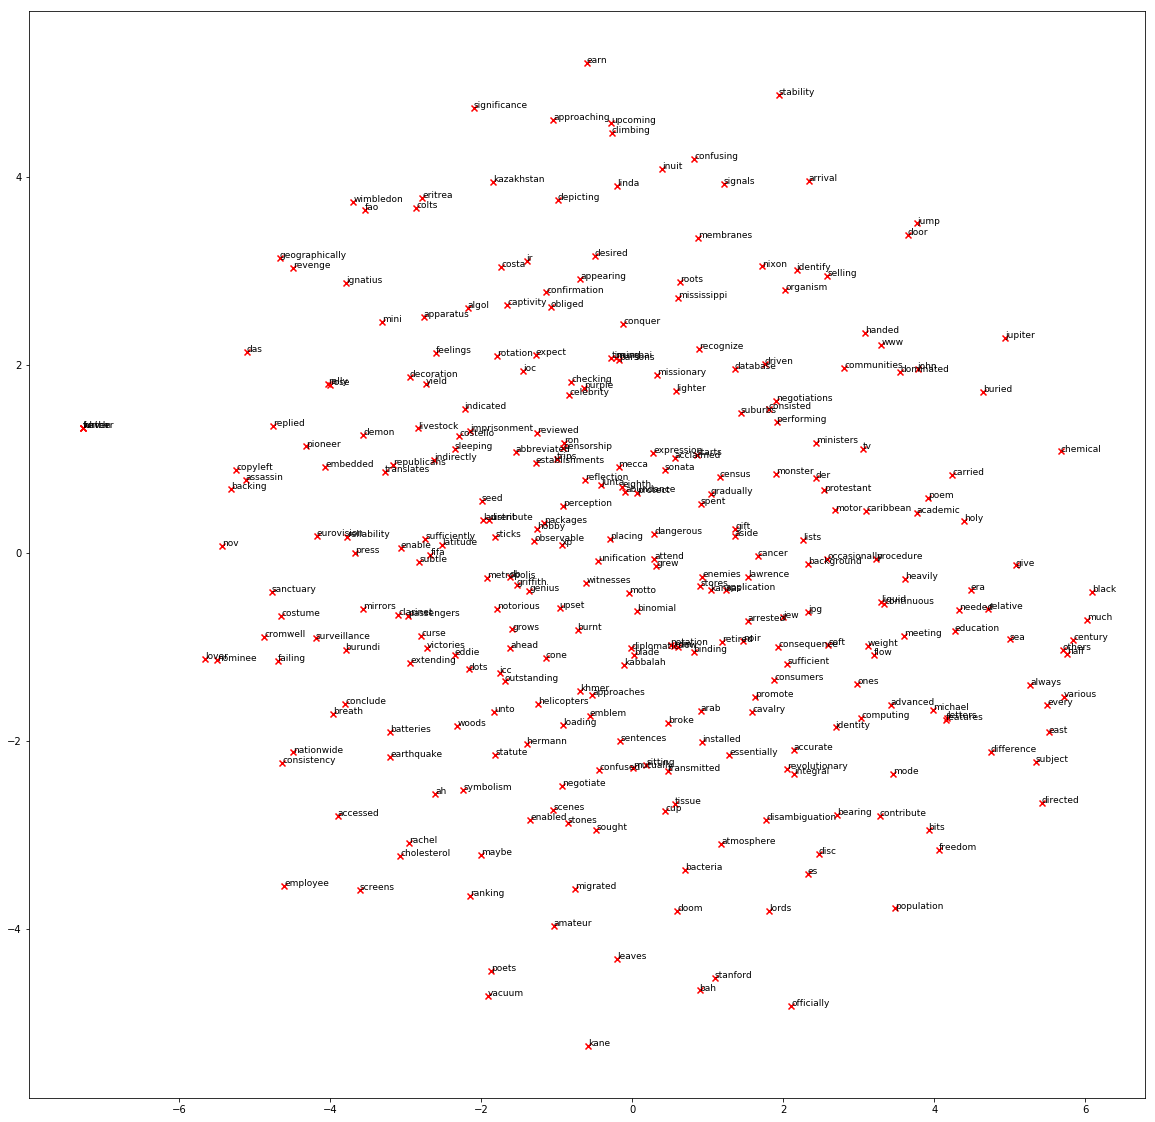

36321it [12:50, 48.63it/s]

In [25]:
plot_embeddings(X, batcher.word2ind, words)

In [26]:
from part3 import Index

In [32]:
%%time
idx = Index(model, vocab, batcher, get_decode_emb, device)

CPU times: user 7.1 s, sys: 199 ms, total: 7.3 s
Wall time: 7.3 s


In [33]:
idx.most_similar(['teen'], k=20)

[('teen', 0.0),
 ('central', 0.9606839907818288),
 ('entire', 0.9652925134962658),
 ('balls', 0.9773608492080429),
 ('horse', 0.979399808899306),
 ('call', 0.9821937250613062),
 ('gradually', 0.9839893069868676),
 ('groups', 0.9849072788379727),
 ('level', 0.9865048996039485),
 ('exposition', 0.9872647210397979),
 ('events', 0.9896688859331588),
 ('remains', 0.9901929617203051),
 ('possible', 0.9902379263488771),
 ('control', 0.990331219935294),
 ('notable', 0.9903834605049995),
 ('administrative', 0.9905854454928333),
 ('jesus', 0.990617064916557),
 ('corporation', 0.9908627053397104),
 ('event', 0.9916869575497562),
 ('hadith', 0.9921064569009951)]

In [34]:
idx.most_similar(['man'], k=20)

[('man', 0.0),
 ('would', 0.6640922090953117),
 ('used', 0.6850491317128202),
 ('first', 0.6924566705692456),
 ('number', 0.7047596262287591),
 ('known', 0.7084836426369738),
 ('made', 0.7100598293939531),
 ('time', 0.7103985850325446),
 ('later', 0.7165474938586051),
 ('church', 0.7187260748156871),
 ('still', 0.7199358073069857),
 ('case', 0.7218284608445579),
 ('called', 0.7222523153181455),
 ('became', 0.7222979507928452),
 ('many', 0.7240876738642488),
 ('sometimes', 0.7256148115653587),
 ('use', 0.7263381775788865),
 ('states', 0.7265992514226592),
 ('system', 0.727764079480277),
 ('found', 0.7304757265787954)]

In [35]:
idx.most_similar(pos=['woman', 'king'], neg=['man'], k=20)

[('woman', 0.7245546304839232),
 ('king', 0.7532604792132169),
 ('twelve', 0.9532244896165202),
 ('good', 0.9656723109633282),
 ('though', 0.9785886269023707),
 ('name', 0.9810589233768735),
 ('hit', 0.9820696159400684),
 ('thought', 0.9823138744531278),
 ('held', 0.9824056756748739),
 ('recent', 0.9829588497586808),
 ('south', 0.9829773138519408),
 ('control', 0.9839992108652006),
 ('mountain', 0.9842400231237253),
 ('characteristics', 0.9851418490344239),
 ('included', 0.9855187144812954),
 ('typically', 0.9875351573625),
 ('position', 0.9875874553052876),
 ('city', 0.9900772301094841),
 ('god', 0.9901079627614273),
 ('might', 0.9906852944493749)]

In [36]:
idx.most_similar(pos=['usa', 'london'], neg=['england'], k=20)

[('london', 0.8163156413488167),
 ('usa', 0.8213536149827213),
 ('martial', 1.0081056863314692),
 ('offer', 1.0314055816736065),
 ('hearing', 1.0316508698884588),
 ('furthermore', 1.038486292264169),
 ('play', 1.0406833139754272),
 ('numerous', 1.041161961674663),
 ('styles', 1.0418586681163735),
 ('creating', 1.0419638146324555),
 ('insulin', 1.042406709371011),
 ('best', 1.0438674312477496),
 ('attack', 1.045196269006709),
 ('consequence', 1.0453452705298574),
 ('popular', 1.0455213306792326),
 ('following', 1.0460257430473678),
 ('union', 1.0474107993846262),
 ('suggest', 1.047595615893844),
 ('former', 1.047987844629629),
 ('known', 1.048231356461593)]